# Лабораторная работа 8
Кластеризация

Выполнила: Кривоконева Екатерина, группа 6133

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as shc

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import v_measure_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from tqdm import tqdm

import warnings
import sys  
warnings.simplefilter("ignore")

## 0 Найти датасет для кластеризации

Датасет: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset


Числовые признаки:

- id - Unique id
- age - Age
- hypertension - Hypertension binary feature
- heart_disease - Heart disease binary feature
- avg_glucose_level - Average glucose level in blood
- bmi - Body Mass Index
- stroke - Stroke event

Категориальные признаки:

- gender - Gender
- work_type - Work type of the patient
- Residence_type - Residence type of the patient
- smoking_status - Smoking status of the patient

Бинарные признаки:

- ever_married - Has the patient ever been married? (true/false)


In [2]:
data = pd.read_csv('data/healthcare-dataset-stroke-data.csv')
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [4]:
# A really fantsatic and intelligent way to deal with blanks, from Thoman Konstantin in: https://www.kaggle.com/thomaskonstantin/analyzing-and-modeling-stroke-data

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor

DT_bmi_pipe = Pipeline( steps=[
                               ('scale',StandardScaler()),
                               ('lr',DecisionTreeRegressor(random_state=42))
                              ])
X = data[['age', 'gender', 'bmi']].copy()
X.gender = X.gender.replace({'Male':0, 'Female':1, 'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
DT_bmi_pipe.fit(X,Y)
predicted_bmi = pd.Series(DT_bmi_pipe.predict(Missing[['age', 'gender']]),index=Missing.index)
data.loc[Missing.index,'bmi'] = predicted_bmi

In [5]:
print('Missing values: ', sum(data.isnull().sum()))

Missing values:  0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                5110 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Преобразуем категориальные признаки в бинарные:

In [7]:
data.gender = data.gender.replace({'Male':0, 'Female':1, 'Other':-1}).astype(np.uint8)
data.Residence_type = data.Residence_type.replace({'Urban':0, 'Rural':1}).astype(np.uint8)
data.ever_married = data.ever_married.replace(['No', 'Yes'], [0, 1])
data['smoking_status'] = data['smoking_status'].astype('category').cat.codes
data['work_type'] = data['work_type'].astype('category').cat.codes

In [8]:
features, target = data.drop('work_type', axis=1), data.work_type

## 1 Выполните иерархическую агломеративную кластеризацию (scipy.cluster.hierarchy), постройте график-дендрограмму (hierarchy.dendrogram)

In [9]:
features_c = features.iloc[:300]
target_c = target.iloc[:300]

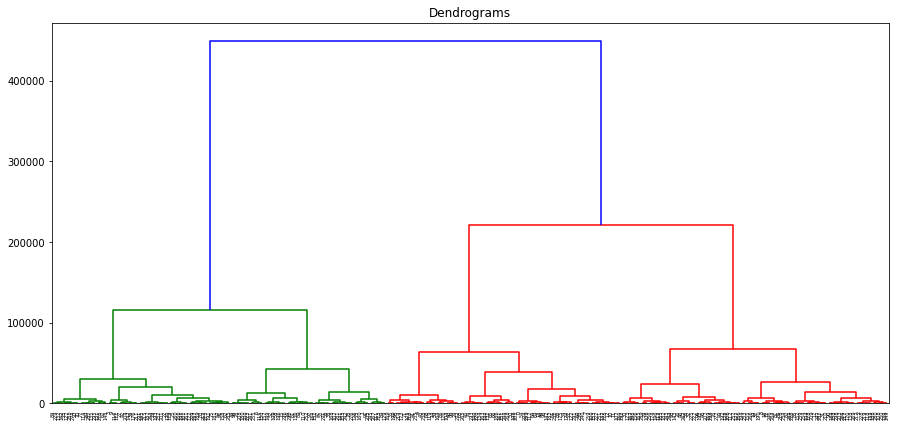

In [10]:
plt.figure(figsize=(15, 7))  
plt.title("Dendrograms") 

clusters = shc.linkage(features_c, 'ward')
dend =  shc.dendrogram(clusters,             
                       distance_sort='descending',
                       show_leaf_counts=True)

## 2 На том же датасете выподните кластеризацию, используя любой другой метод кластеризации (пока с произвольными гиперпараметрами)

In [11]:
kmean_cluster = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmean_cluster.fit_predict(features_c)

In [12]:
print(
    "ARI:", adjusted_rand_score(target_c, cluster_labels),
    "\nAMI:", adjusted_mutual_info_score(target_c, cluster_labels),
    "\nHomogeneity:", homogeneity_score(target_c, cluster_labels),
    "\nCompleteness:", completeness_score(target_c, cluster_labels),
    "\nV-measure:", v_measure_score(target_c, cluster_labels),
    "\nSilhouette:", silhouette_score(features_c, cluster_labels)
    )

ARI: -0.0015232319979556891 
AMI: 0.004375963045966295 
Homogeneity: 0.0321117220468154 
Completeness: 0.02041592317446011 
V-measure: 0.024961730058360332 
Silhouette: 0.5666922850167203


## 3 Выполните оптимизацию гиперпараметров кластеризации

В качестве настраиаемого гиперпараметра будет использован n_clusters. Метрика для оптимизации - ARI.

In [13]:
n_clusters = [*range(2,21,1)]

In [14]:
ari_scores = []
for _, cluster in tqdm(enumerate(n_clusters)):
  clusterer = KMeans(n_clusters=cluster, random_state=0)
  cluster_labels = clusterer.fit_predict(features_c)
  ari_scores.append(adjusted_rand_score(target_c, cluster_labels))

19it [00:11,  1.64it/s]


In [15]:
idx_max = ari_scores.index(max(ari_scores))
print('Лучшее значение ARI: ', ari_scores[idx_max])

Лучшее значение ARI:  0.0025909917541340225


In [16]:
# посмотрим также чему равны другие метрики

kmean_cluster = KMeans(n_clusters=n_clusters[idx_max], random_state=0)
cluster_labels = kmean_cluster.fit_predict(features_c)

print(
    "AMI:", adjusted_mutual_info_score(target_c, cluster_labels),
    "\nHomogeneity:", homogeneity_score(target_c, cluster_labels),
    "\nCompleteness:", completeness_score(target_c, cluster_labels),
    "\nV-measure:", v_measure_score(target_c, cluster_labels),
    "\nSilhouette:", silhouette_score(features_c, cluster_labels)
    )

AMI: 0.010795078524097175 
Homogeneity: 0.07817516971005188 
Completeness: 0.033368960404469204 
V-measure: 0.04677295237300496 
Silhouette: 0.5582326698074817


## 4 Используя алгоритм/модель из п. 2 выполните оптимизацию гиперпараметра количества кластеров, используя "правило локтя" (анализируем график силуэта)

In [17]:
scores = []
for _, cluster in tqdm(enumerate(n_clusters)):
    clusters = KMeans(n_clusters=cluster, random_state=42).fit_predict(features)
    scores.append(silhouette_score(features, clusters))

19it [00:27,  1.44s/it]


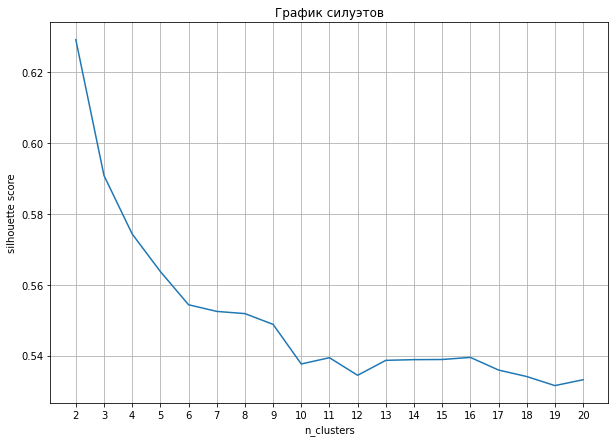

In [21]:
fig, ax = plt.subplots(figsize=(10,7))
ax.plot(n_clusters, scores)
ax.set(title='График силуэтов', xlabel='n_clusters', ylabel='silhouette score')
ax.set_xticks(n_clusters)
ax.grid()
plt.show()

Заметный перелом графика произошел при n_clusters = 6.